In [1]:
!nvidia-smi

Fri Jan 23 11:48:17 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.195.03             Driver Version: 570.195.03     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   43C    P8              4W /   55W |     670MiB /   8188MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  
print("GPU Details:", tf.config.list_physical_devices('GPU'))

2026-01-23 11:48:23.056005: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow version: 2.20.0
Num GPUs Available:  1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
import sys
sys.path.append("..")

from load_dataset import load_dataset

train_gen, val_gen, train_gen_class_indc = load_dataset(batch_size=256)

Found 33240 images belonging to 8 classes.
Found 8306 images belonging to 8 classes.


# Model == AlexNet

In [ ]:
from tensorflow.keras import layers, models

def build_spatial_core(num_classes=8):
    inp = layers.Input(shape=(None, None, 3))

    # ===============================
    # ALEXNET CONV BACKBONE
    # ===============================
    x = layers.Conv2D(96, 11, strides=4, activation="relu", padding="valid")(inp)
    x = layers.MaxPooling2D(3, strides=2)(x)

    x = layers.Conv2D(256, 5, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(3, strides=2)(x)

    x = layers.Conv2D(384, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(384, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(3, strides=2)(x)

    # ===============================
    # FC → CONV (AlexNet style)
    # 224×224 → 1×1 here
    # ===============================
    x = layers.Conv2D(512, 1, activation="relu")(x)
    x = layers.Conv2D(128, 1, activation="relu")(x)

    # ===============================
    # CLASS LOGITS PER WINDOW
    # ===============================
    out = layers.Conv2D(num_classes, 1)(x)

    return models.Model(inp, out, name="alexnet_spatial_core")


In [8]:
def build_training_model(spatial_core, num_classes=8):
    inp = layers.Input(shape=(224, 224, 3))

    x = spatial_core(inp)          # (1,1,C)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Activation("softmax")(x)

    return models.Model(inp, out, name="training_model")


In [9]:
spatial_core = build_spatial_core(num_classes=len(train_gen_class_indc))
training_model = build_training_model(spatial_core, num_classes=len(train_gen_class_indc))

I0000 00:00:1769149191.129700   42575 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5474 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [10]:
spatial_core.summary()

Model: "alexnet_spatial_core"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, None, 96) │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, None, None, 96) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None,     │       614,656 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None,     │       885,120 │
│                                 │ 384)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None,     │     1,327,488 │
│                                 │ 384)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, None, None,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, None,     │    26,218,496 │
│                                 │ 4096)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, None, None,     │    16,781,312 │
│                                 │ 4096)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, None, None, 8)  │        32,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,779,784 (178.45 MB)

 Trainable params: 46,779,784 (178.45 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
training_model.summary()

Model: "training_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ alexnet_spatial_core            │ (None, 1, 1, 8)        │    46,779,784 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 8)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,779,784 (178.45 MB)

 Trainable params: 46,779,784 (178.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint(
        filepath="best_AlexNet.keras",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=7,
        min_lr=1e-7,
        verbose=1
    )
]


In [ ]:
training_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy" ]
)


In [17]:
# ensuring model fits on GPU
history = training_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=1,
    callbacks=callbacks
)

2026-01-23 11:50:20.844650: I external/local_xla/xla/service/service.cc:163] XLA service 0x724de00118b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-23 11:50:20.844679: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2026-01-23 11:50:20.876330: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-23 11:50:21.131761: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2026-01-23 11:50:32.591581: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng2{k2=1,k3=0} for conv (f32[256,256,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,4096,1,1]{3,2,1,0}, f32[4096,256,5,5]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend

  1/130 ━━━━━━━━━━━━━━━━━━━━ 1:18:16 36s/step - accuracy: 0.1445 - loss: 2.0819

I0000 00:00:1769149253.810385   43664 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  3/130 ━━━━━━━━━━━━━━━━━━━━ 2:10 1s/step - accuracy: 0.1753 - loss: 2.0490   

KeyboardInterrupt: 

In [18]:
# Training Model 
history = training_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=callbacks
)

/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/100
 43/130 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - accuracy: 0.2202 - loss: 1.9084

/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 71/130 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.2275 - loss: 1.8988

2026-01-23 11:54:15.303006: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng25{k2=0,k3=0} for conv (f32[216,256,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[216,4096,1,1]{3,2,1,0}, f32[4096,256,5,5]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2026-01-23 11:54:15.519158: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.216227034s
Trying algorithm eng25{k2=0,k3=0} for conv (f32[216,256,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[216,4096,1,1]{3,2,1,0}, f32[4096,256,5,5]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2423 - loss: 1.8763
Epoch 1: val_loss improved from None to 1.75755, saving model to best_AlexNet.keras

Epoch 1: finished saving model to best_AlexNet.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 365s 3s/step - accuracy: 0.2786 - loss: 1.8188 - val_accuracy: 0.3013 - val_loss: 1.7575 - learning_rate: 1.0000e-04
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3613 - loss: 1.6692
Epoch 2: val_loss did not improve from 1.75755
130/130 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.3792 - loss: 1.6372 - val_accuracy: 0.3649 - val_loss: 1.7623 - learning_rate: 1.0000e-04
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4197 - loss: 1.5457
Epoch 3: val_loss improved from 1.75755 to 1.67008, saving model to best_AlexNet.keras

Epoch 3: finished saving model to best_AlexNet.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.4260 - loss: 1.5288 - val_accuracy: 0.3686 - val_loss: 1.6701 - learning_rate: 1

In [30]:
spatial_core.summary()

Model: "alexnet_spatial_core"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, None, 96) │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, None, None, 96) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None,     │       614,656 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None,     │       885,120 │
│                                 │ 384)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None,     │     1,327,488 │
│                                 │ 384)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, None, None,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, None,     │    26,218,496 │
│                                 │ 4096)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, None, None,     │    16,781,312 │
│                                 │ 4096)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, None, None, 8)  │        32,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,779,784 (178.45 MB)

 Trainable params: 46,779,784 (178.45 MB)

 Non-trainable params: 0 (0.00 B)

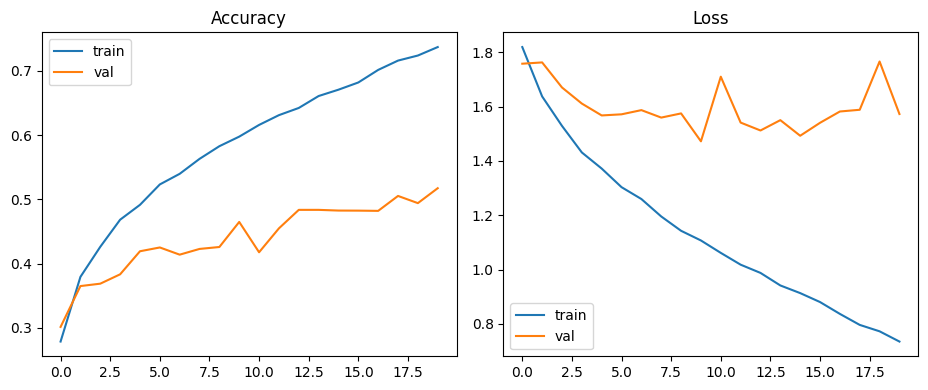

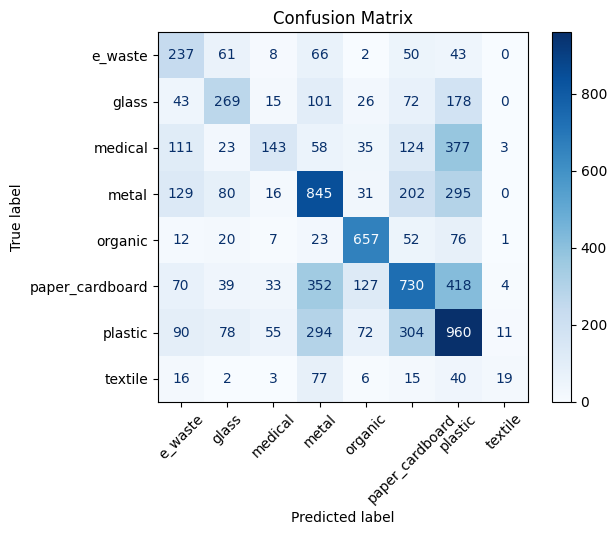

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6374907].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8194897].


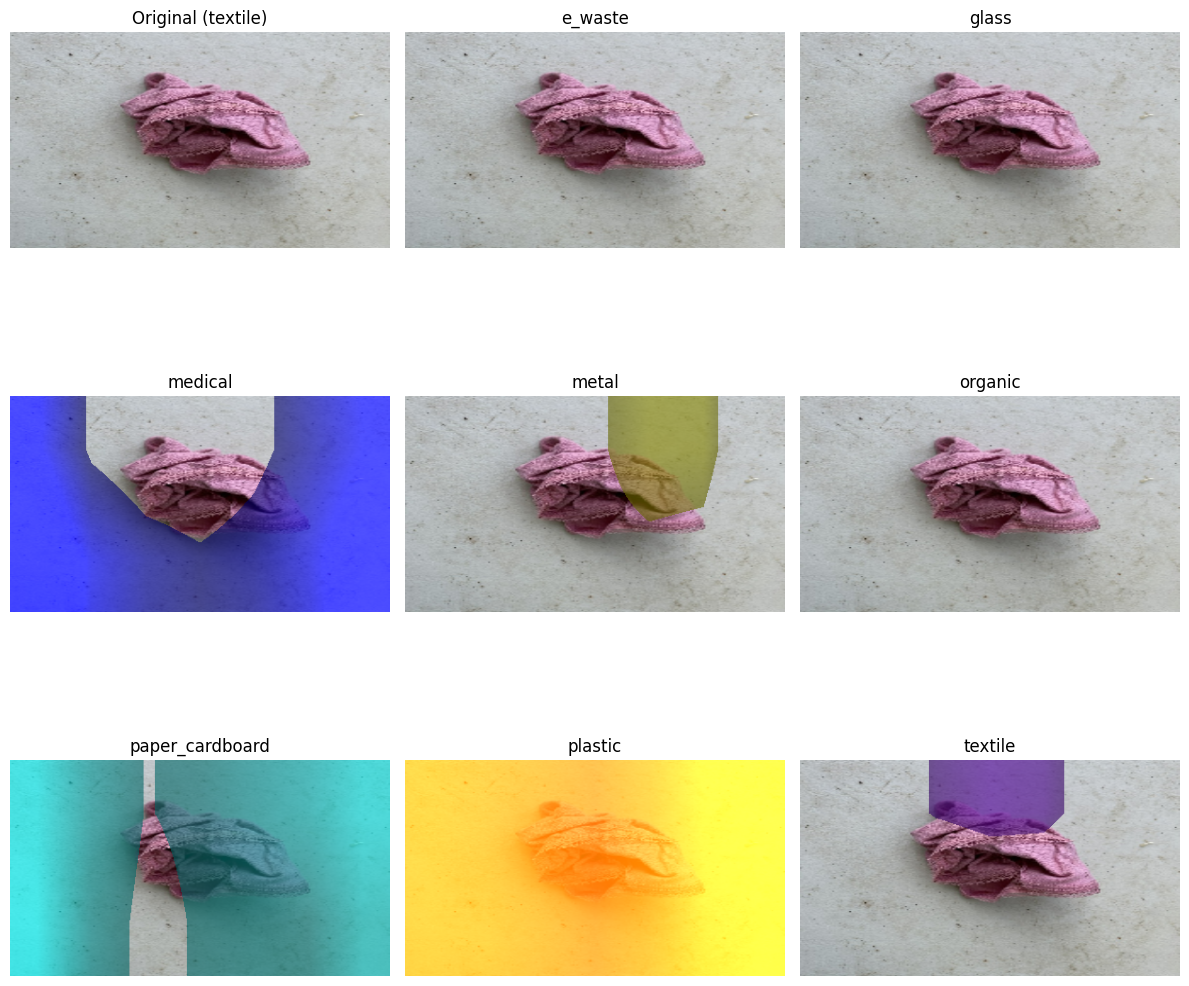

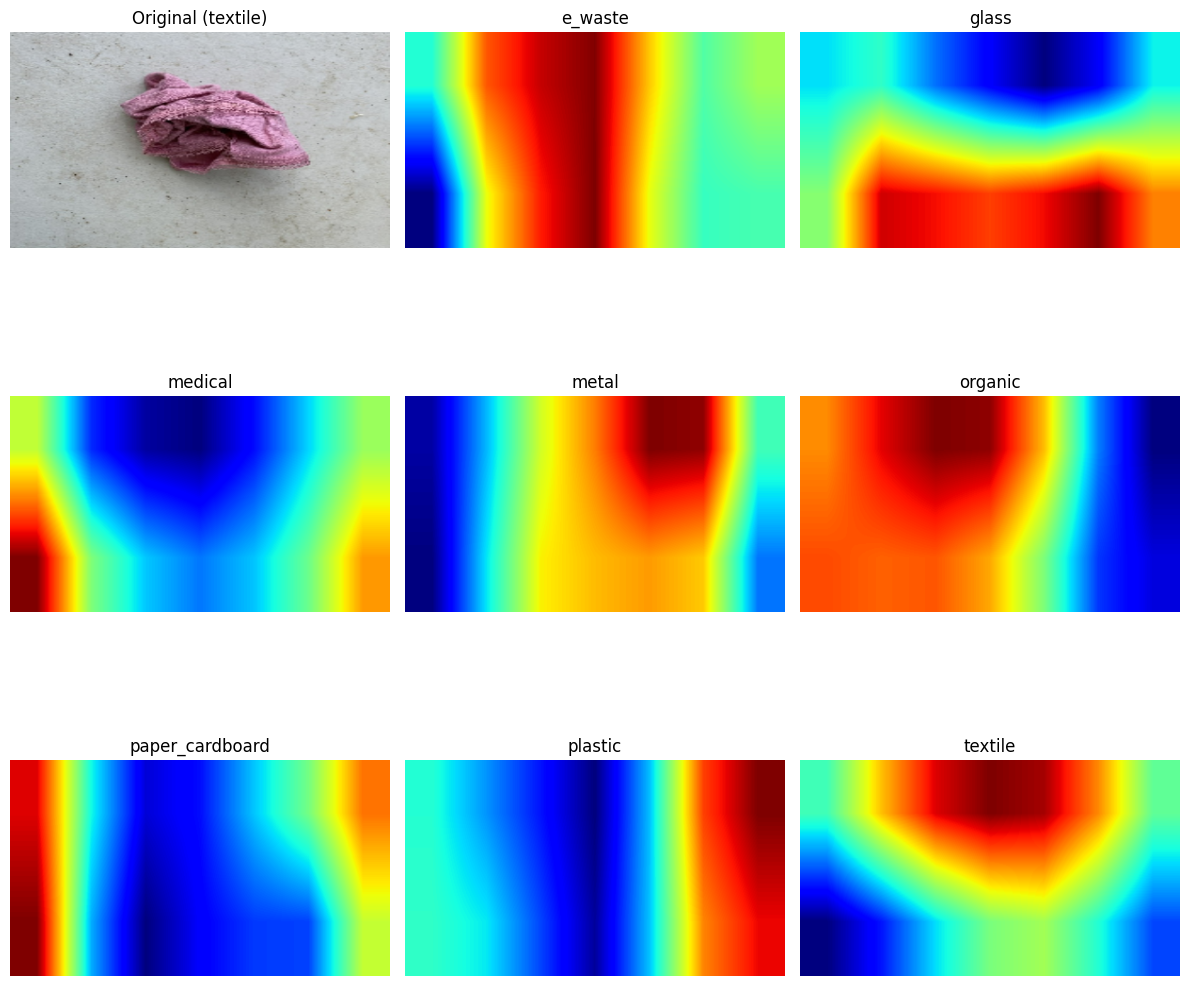

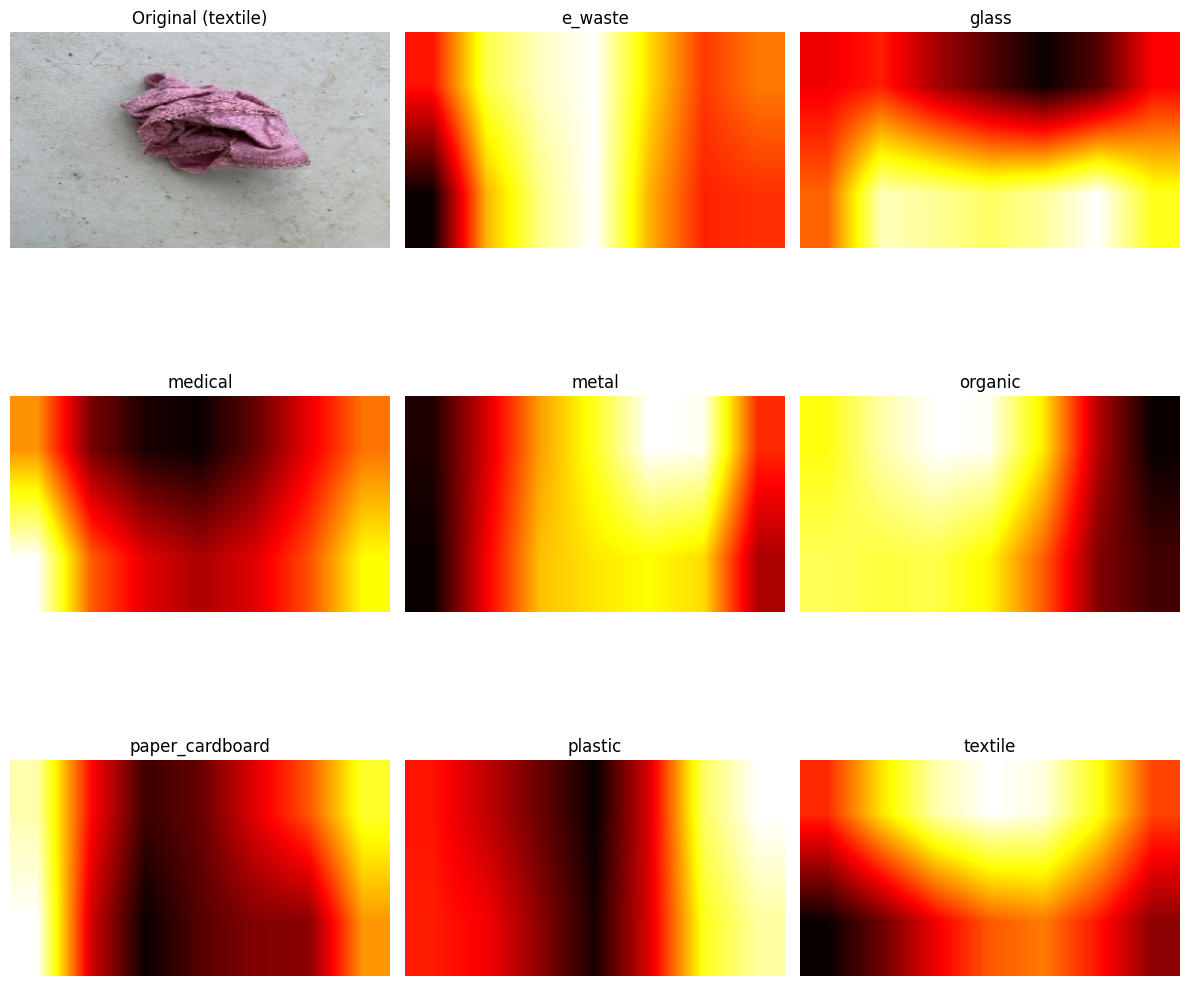

In [26]:
# assume these already exist
# train_model   -> model used for training / classification
# spatial_core  -> sliding FCN (same weights)
# history       -> returned by model.fit(...)
# val_gen       -> validation ImageDataGenerator
# class_indices -> from train_gen.class_indices

from test_model import ModelTester

tester = ModelTester(model=training_model,history=history,val_gen=val_gen,class_indices=train_gen_class_indc)

# training diagnostics
tester.plot_history()
tester.plot_confmat()

# spatial diagnostics (ONE image, all plots)
tester.show_all(spatial_core)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0006810806..1.0303619].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00055404834..2.2814322].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0013851208..1.3277063].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.002083589..1.7770877].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00027243225..1.9586711].


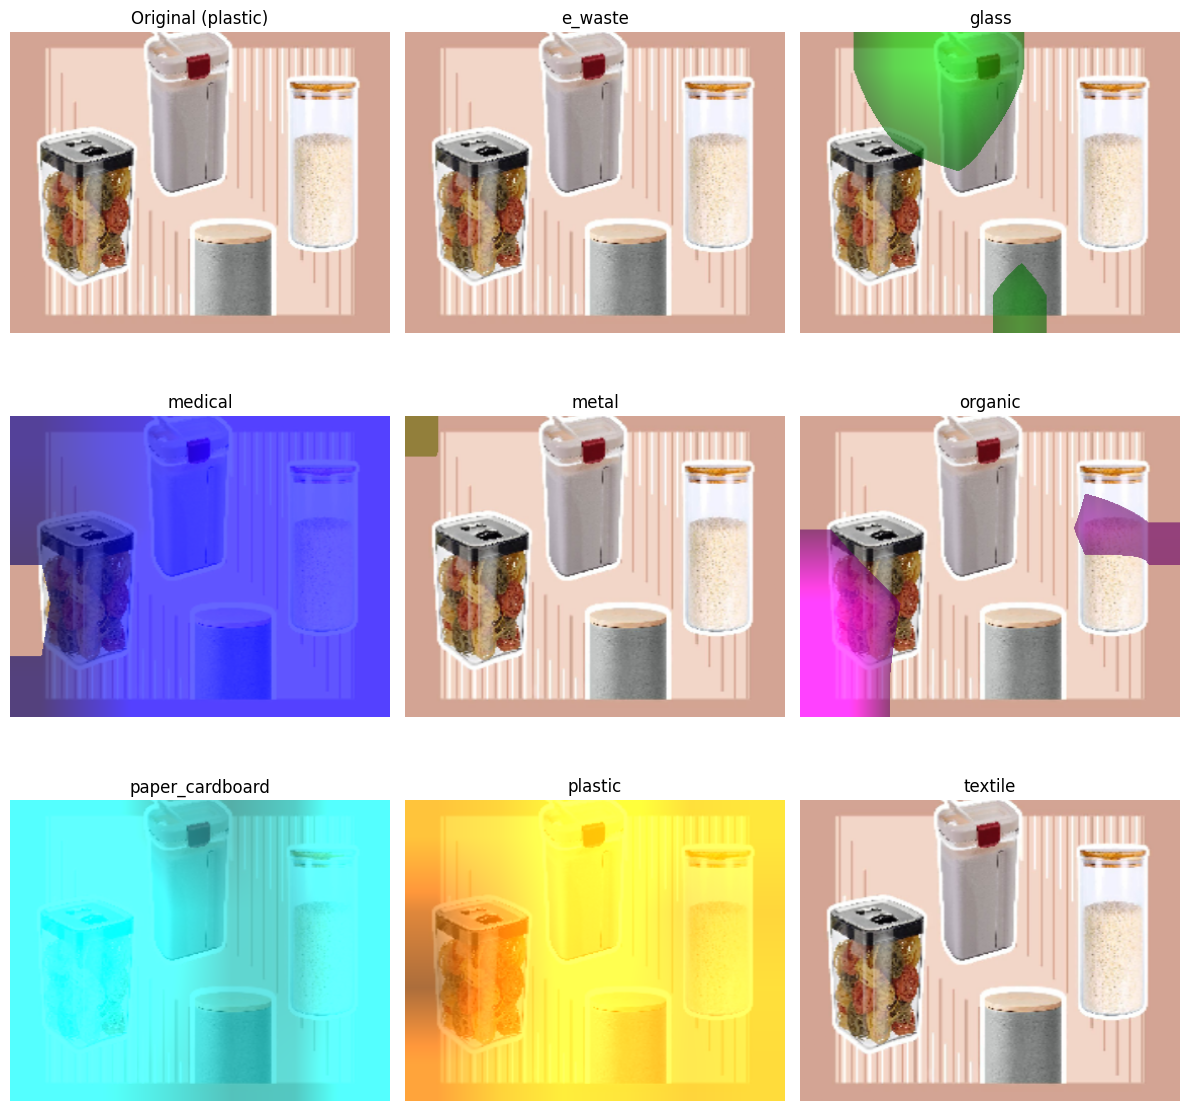

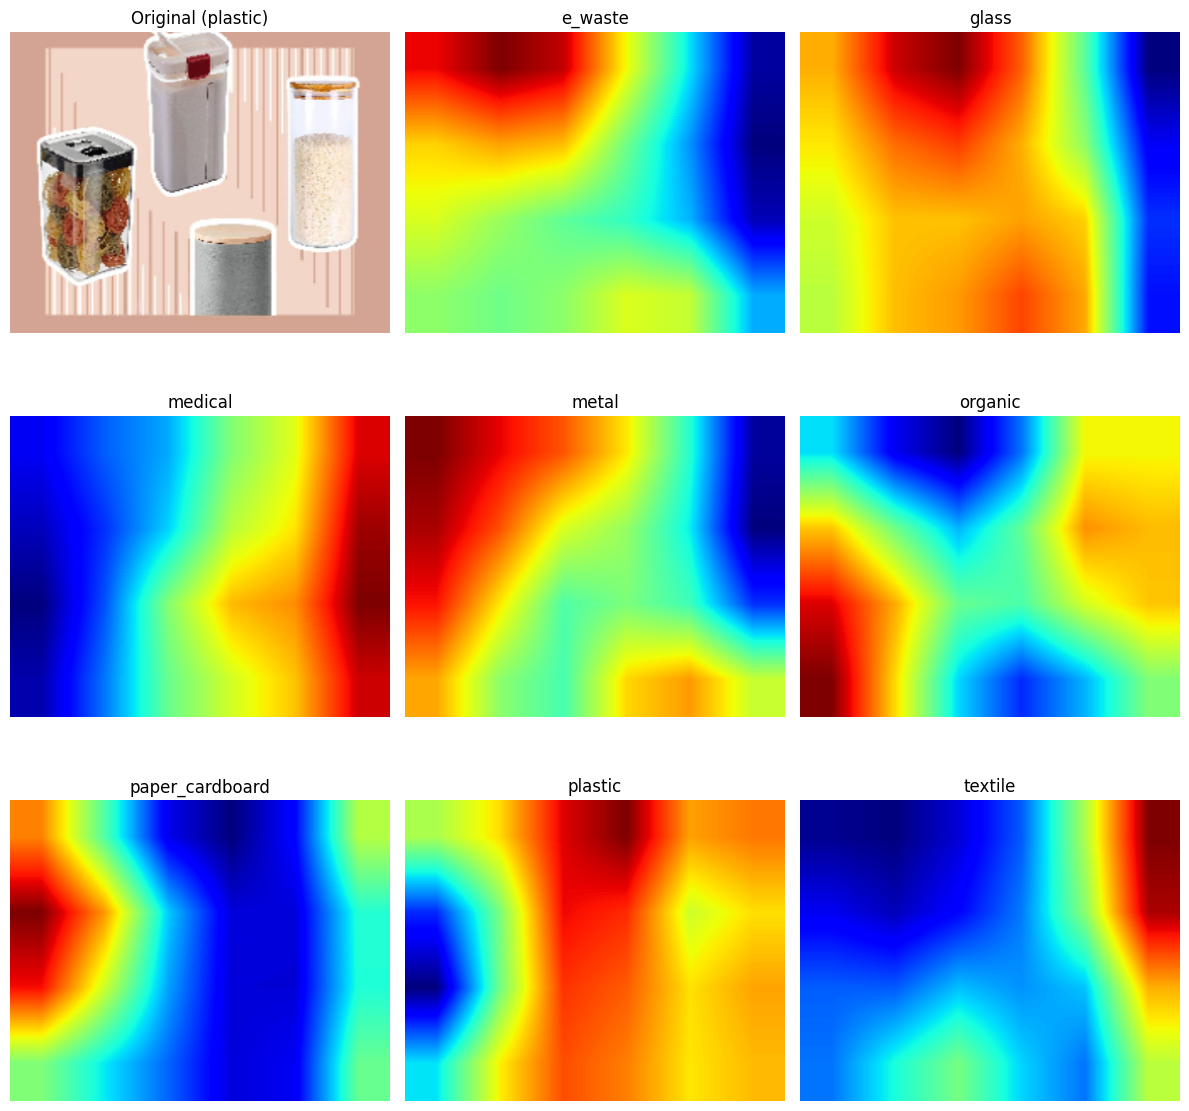

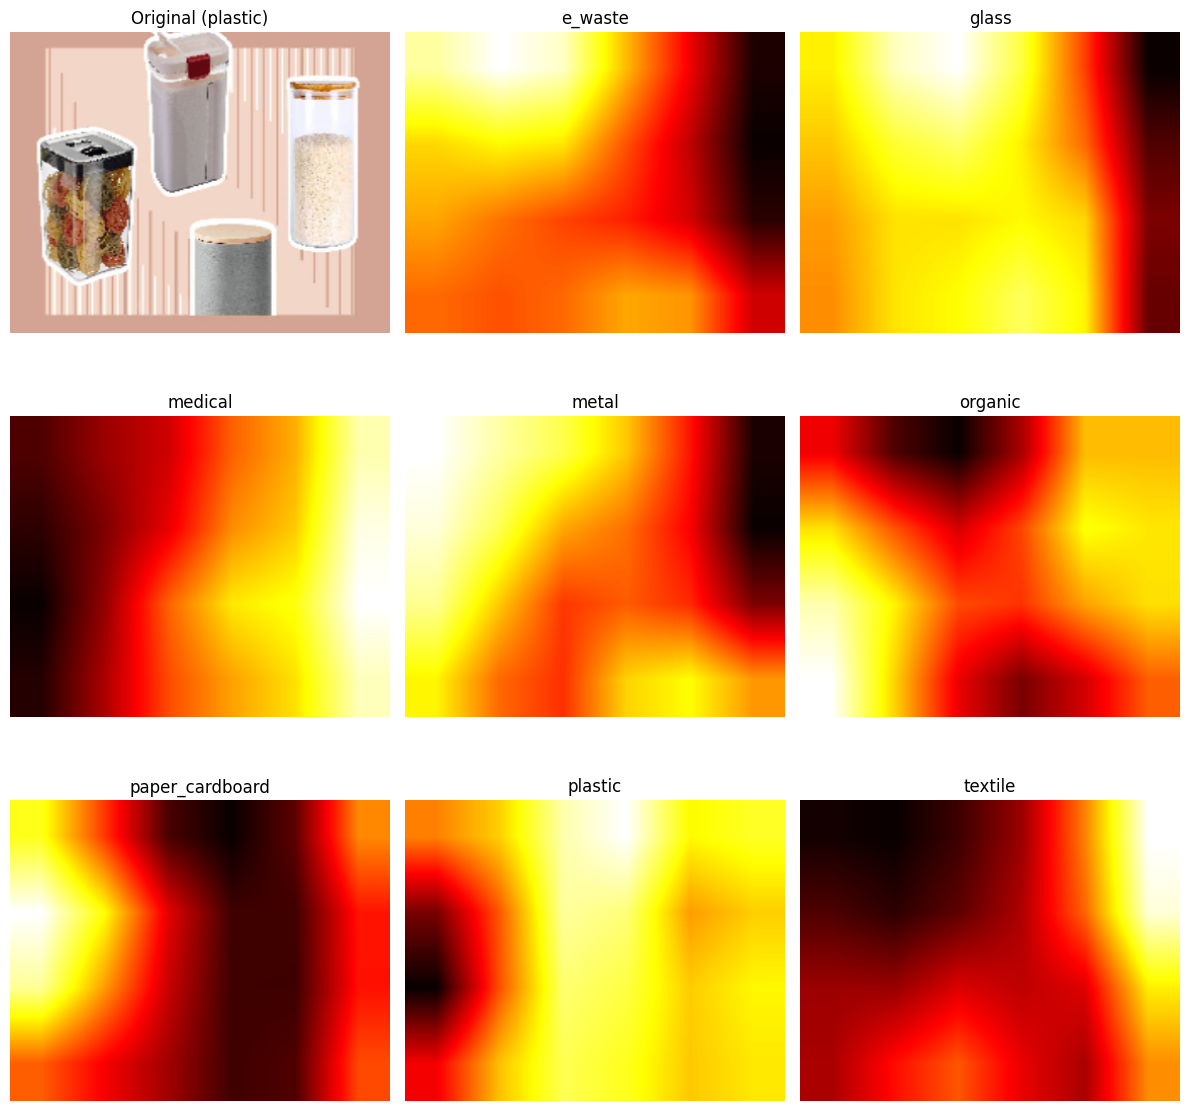

In [29]:
tester.show_all(spatial_core)